In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Add project code
import sys
sys.path.append('/eai/project/')

In [ ]:
import json
import os 
import pickle

import numpy as np
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset
from collections import Counter

from embedding.model import Model
from embedding.utils import normalize
from embedding.utils import plot_splits
from embedding.preprocess_fashion import create_captions, dump_all
from embedding.train_embedding_model import get_split

BATH_SIZE = 100
IMG_SIZE = 256

# Img resizing stuff
LR_HR_RATIO = 4
BIG_SIZE = int(IMG_SIZE * 76 / 64)
SMALL_SIZE = int(BIG_SIZE / LR_HR_RATIO)

FASHION_PATH  = '/fashion/'
DATA_PATH     = '/data/fashion/'
DATA_TEMPLATE =  os.path.join(FASHION_PATH, 'ssense_%i_%i.h5')

MODEL_PATH = '/models/fashion/'
LIMIT = 70

In [86]:
! ls { FASHION_PATH }

ssense_128_128.h5  ssense_256_256.h5  ssense_512_512.h5  ssense_full_size.h5


## Load categories

In [ ]:
category2idx = json.load(open(os.path.join(DATA_PATH, 'categories.json'), 'rt'))

## Load all the data into memory

In [ ]:
dataset = H5PYDataset(DATA_TEMPLATE % (IMG_SIZE, IMG_SIZE), 
                      sources = ['input_category', 'input_description', 'input_image'],
                      which_sets=('all',),  load_in_memory=True)

classes, texts, images = dataset.data_sources

classes = np.array([cls[0] for cls in classes])
texts   = np.array([txt[0] for txt in texts])

print("N. examples: %i, fst: %s" %(len(classes), classes[0]))
print(texts.shape, images.shape, classes.shape)

# Preprocessing

### Create captions and filenames

In [ ]:
# prepare filenames
filenames = create_captions(classes, texts, category2idx)
print("N. files: %i, fst: %s" % (len(filenames), filenames[0]))

### Create stratified split

Due to the fact, that we have high clas imbalance we have to split the dataset using stratified samplig

In [88]:
train_idx, test_idx, _, _ = get_split(classes, classes.reshape(-1, 1), 0.1, seed=2)

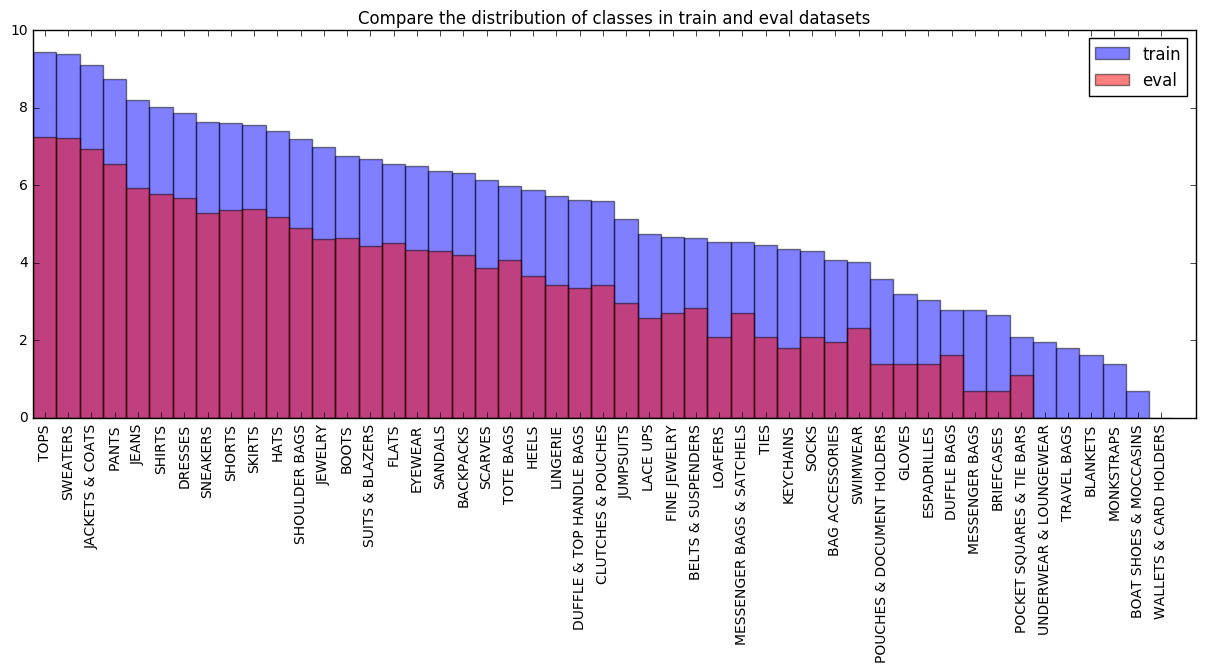

In [89]:
plot_splits(
    train_classes = classes[train_idx],
    test_classes  = classes[test_idx]
)

### Create embeddings

In [ ]:
model = Model(
    os.path.join(MODEL_PATH, 'frozen_model.pb'),
    os.path.join(MODEL_PATH, 'tokenizer.pickle'),
    maxlen = LIMIT
)

## Dump data do text_10 format

In [ ]:
dump_all(classes, filenames, images, texts, test_idx, model, '/data/fashion/test')

In [ ]:
dump_all(classes, filenames, images, texts, train_idx, model, '/data/fashion/train')

# Birds dataset

In [ ]:
# print some statistics to know how to split fashion dataset
train_size = 8855
test_size = 2933
print("%.02f" % (1.0 * train_size / (train_size + test_size)))

In [ ]:
data_path = '/data/birds/test/'

In [ ]:
!ls { data_path }

In [ ]:
birds_class_info        = pickle.load(open(os.path.join(data_path, 'class_info.pickle'), 'rb'))
birds_filenames         = pickle.load(open(os.path.join(data_path, 'filenames.pickle'), 'rb'))
birds_images76          = pickle.load(open(os.path.join(data_path, '76images.pickle'), 'rb'))
birds_custom_embeddings = pickle.load(open(os.path.join(data_path, 'custom-embeddings.pickle'), 'rb'))

In [ ]:
len(birds_class_info), birds_class_info[0]

In [ ]:
len(birds_filenames), birds_filenames[0]

In [ ]:
birds_filenames[:5]

In [ ]:
type(birds_images76), len(birds_images76), birds_images76[0].shape

In [ ]:
type(birds_custom_embeddings), len(birds_custom_embeddings), birds_custom_embeddings[0].shape

In [ ]:
birds_custom_embeddings[0]

### text_c10 folder

In [ ]:
! ls /data/birds/text_c10/ | head 

In [ ]:
! ls /data/birds/text_c10/001.Black_footed_Albatross  | head

In [ ]:
! cat /data/birds/text_c10/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.txt